**reference**  
http://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html

In [83]:
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
import torch
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform

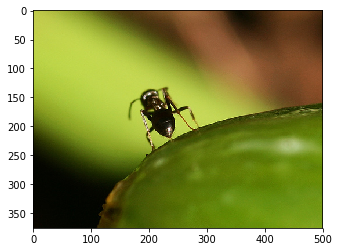

In [106]:
image = Image.open("hymenoptera_data/val/ants/1337725712_2eb53cd742.jpg")
imshow(image)

In [107]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [108]:
tensor = preprocess(image)

In [109]:
prediction_var = Variable((tensor.unsqueeze(0)), requires_grad=True)

In [110]:
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('params.pkl'))

In [111]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [112]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [113]:
final_layer = model._modules.get('layer4')

In [114]:
activated_features = SaveFeatures(final_layer)

In [115]:
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

c:\users\gtw\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [116]:
topk(pred_probabilities,1)

(tensor([ 0.9780]), tensor([ 0]))

In [117]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]


In [118]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [119]:
weight_softmax_params

[Parameter containing:
 tensor(1.00000e-02 *
        [[-1.5923, -2.3019,  1.6556,  ..., -5.3536,  1.5509,  0.9852],
         [ 0.0116,  0.1952, -2.8447,  ..., -0.5404, -0.9083, -3.8404]]),
 Parameter containing:
 tensor(1.00000e-02 *
        [-2.3517,  0.5820])]

In [120]:
class_idx = topk(pred_probabilities,1)[1].int()

In [121]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

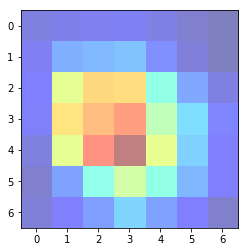

In [122]:
imshow(overlay[0], alpha=0.5, cmap='jet')

c:\users\gtw\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\gtw\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


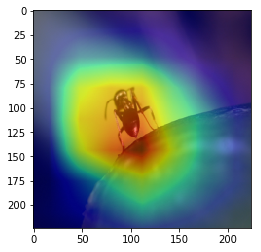

In [123]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

In [124]:
class_idx = topk(pred_probabilities,2)[1].int()

In [125]:
class_idx

tensor([ 0,  1], dtype=torch.int32)

In [126]:
overlay = getCAM(activated_features.features, weight_softmax, 1 )


c:\users\gtw\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\gtw\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


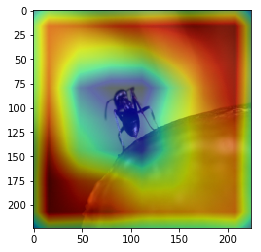

In [127]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');